In [1]:
import numpy as np
import scipy.stats as stats             # For distribution functions
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d # For 3D graphs

plt.rcParams['axes.axisbelow'] = True   # Set axes and grid elements to be below the figure
# %matplotlib widget

#### Ornstein-Uhlenbeck Process (Vasicek Model)

![Ornstein-Uhlenbeck Process](ornstein-uhlenbeck_process.png)

In [2]:
# Simulation of the Ornstein-Uhlenbeck Process
# Setting Parameters =======================================================================================
N_SIMS = 20000                           # FIXME: number of simulations
N_STEPS = 200                            # FIXME: number of steps (excluding t = 0)
ALPHA = 5                                # FIXME: mean reversion speed
SIGMA = 0.07                             # FIXME: volatility
MU = 0.07                                # FIXME: long-term mean
X0 = 0.03                                # FIXME: initial value
T = 1                                    # FIXME: time horizon

dt = T / N_STEPS
t_steps = np.linspace(0, T, N_STEPS + 1)

# SIMULATION ===============================================================================================
X = np.vstack([np.full(N_SIMS, X0), np.zeros((N_STEPS, N_SIMS))]) # Each row is a time step, each column is a simulation
Y = X.copy()
# Z = rnorm(N_SIMS * N_STEPS).reshape((N_STEPS, N_SIMS))
Z = np.random.normal(size = (N_STEPS, N_SIMS))

# Euler-Maruyama with Analytical Moments
for i in range(N_STEPS):
    X[i + 1] = MU + (X[i] - MU) * np.exp(-ALPHA * dt) + SIGMA * np.sqrt((1 - np.exp(-2 * ALPHA * dt)) / (2 * ALPHA)) * Z[i]

# Plan Euler-Maruyama
for i in range(N_STEPS):
    Y[i + 1] = Y[i] + ALPHA * (MU - Y[i]) * dt + SIGMA * np.sqrt(dt) * Z[i]

# Computing Statistics =====================================================================================
def mean_ou(x0, t, mu, alpha): # Theoretical mean of OU process
    return np.exp(-alpha * t) * x0 + mu * (1 - np.exp(-alpha * t))

def var_ou(x0, t, mu, alpha, sigma): # Theoretical variance of OU process
    return sigma**2 / (2 * alpha) * (1 - np.exp(-2 * alpha * t))

t_steps = np.linspace(0, T, N_STEPS + 1)
sample_mean = X.mean(axis = 1)
sample_var = X.var(axis = 1)
exact_mean = mean_ou(X0, t_steps, MU, ALPHA)
exact_var = var_ou(X0, t_steps, MU, ALPHA, SIGMA)

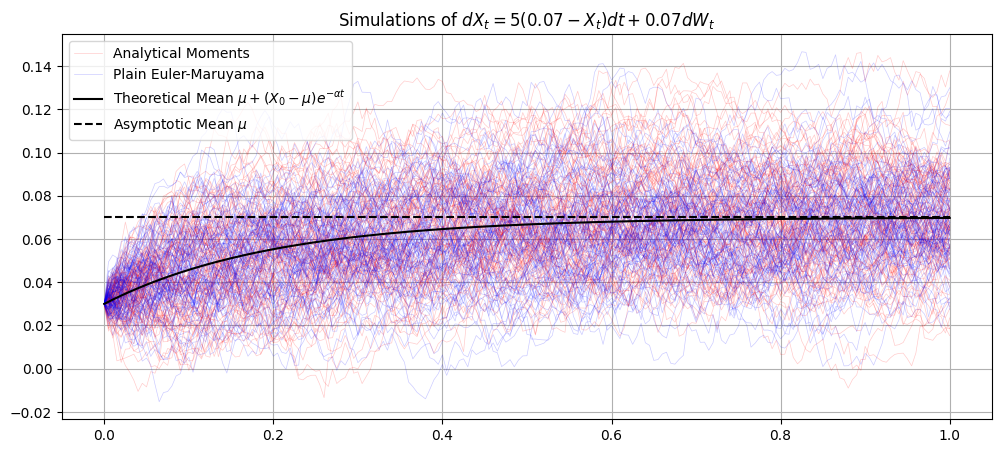

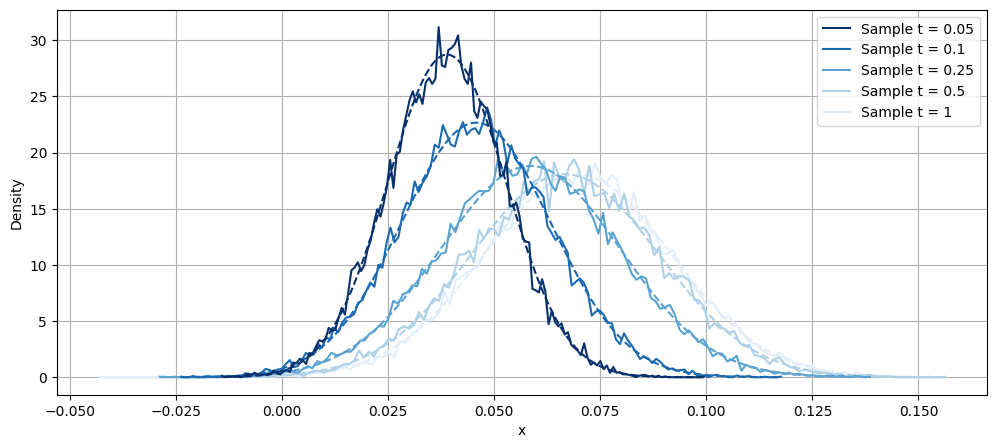

In [6]:
# Trajectories and Slices
# Plotting trajectories ---------------------------------------------------------------
plt.figure(figsize = (12, 5), clear = True)

plt.title(f"Simulations of $dX_t = {ALPHA}({MU}-X_t)dt+{SIGMA}dW_t$")
plt.plot(t_steps, X[:,0:100], color = "red", alpha = 0.2, lw = 0.5, label = "Analytical Moments")
plt.plot(t_steps, Y[:,100:200], color = "blue", alpha = 0.2, lw = 0.5, label = "Plain Euler-Maruyama")
plt.plot(t_steps, MU + (X0 - MU) * np.exp(-ALPHA * t_steps), color = "black", label = r"Theoretical Mean $\mu+(X_0-\mu)e^{-\alpha t}$")
plt.plot(t_steps, np.full(N_STEPS + 1, MU), color = "black", linestyle = "--", label = r"Asymptotic Mean $\mu$")

# Only show one legend for all simulations
handles, labels = plt.gca().get_legend_handles_labels() # This gets the handles and labels of the current axes
by_label = dict(zip(labels, handles)) # dict(zip(keys, values)) is a way to create a dictionary from two lists
plt.legend(by_label.values(), by_label.keys())
plt.grid()

plt.show()

# Slices of OU process ----------------------------------------------------------------
plt.figure(figsize = (12, 5), clear = True)

SLICES = [0.05, 0.1, 0.25, 0.5, 1]

# Use color map to generate colors
# colors = plt.cm.rainbow(np.linspace(0, 1, len(time_slices)))
colors = plt.cm.Blues(np.linspace(0.1, 1, len(SLICES))) # Inverse grey color direction

for i, time in enumerate(SLICES[::-1]):
    # Genearte density information
    p, x = np.histogram(X[int(time * N_STEPS)], bins = 150, density = True)
    x = (x[:-1] + x[1:]) / 2 # Get the middle point of each bin

    loc = mean_ou(X0, time, MU, ALPHA)
    scale = np.sqrt(var_ou(X0, time, MU, ALPHA, SIGMA))
    
    plt.plot(x, p, color = colors[i], label = f"Sample t = {time}")
    plt.plot(x, stats.norm.pdf(x, loc = loc, scale = scale), "--", color = colors[i])

plt.xlabel("x")
plt.ylabel("Density")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])
plt.grid()
plt.show()

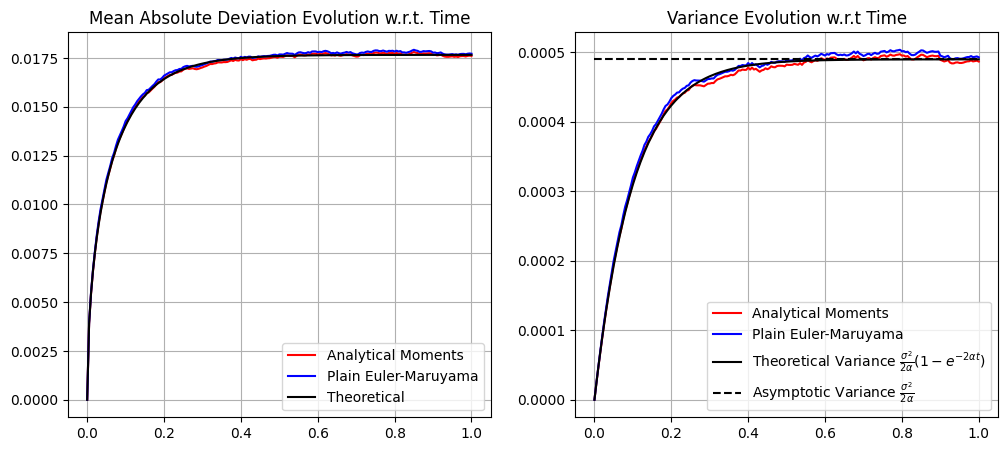

In [4]:
# Plotting MAD and Variance ===========================================================
fig, ax = plt.subplots(1, 2, figsize = (12, 5), clear = True)

ax[0].set_title("Mean Absolute Deviation Evolution w.r.t. Time")

# Sample Mean Absolute Deviation from Theoretical Mean --------------------------------
ax[0].plot(t_steps, np.mean(np.abs(X - exact_mean.reshape((N_STEPS + 1, 1))), axis = 1), color = "red", label = "Analytical Moments")
ax[0].plot(t_steps, np.mean(np.abs(Y - exact_mean.reshape((N_STEPS + 1, 1))), axis = 1), color = "blue", label = "Plain Euler-Maruyama")

# Theoretical Mean Absolute Deviation
ax[0].plot(t_steps, SIGMA * np.sqrt((1 - np.exp(-2 * ALPHA * t_steps)) / (ALPHA * np.pi)), color = "black", label = "Theoretical")

ax[0].grid()
ax[0].legend()

ax[1].set_title("Variance Evolution w.r.t Time")

# Sample variance ---------------------------------------------------------------------
ax[1].plot(t_steps, X.var(axis = 1), color = "red", label = "Analytical Moments")
ax[1].plot(t_steps, Y.var(axis = 1), color = "blue", label = "Plain Euler-Maruyama")

# Theoretical and Asymptotic Variance
ax[1].plot(t_steps, exact_var, color = "black", label = r"Theoretical Variance $\frac{\sigma^2}{2\alpha}(1-e^{-2\alpha t})$")
ax[1].plot(t_steps, np.full(N_STEPS + 1, SIGMA**2 / (2 * ALPHA)), color = "black", linestyle = "--", label = r"Asymptotic Variance $\frac{\sigma^2}{2\alpha}$")

ax[1].grid()
ax[1].legend()

plt.show()

Theoretical covariance with respect to lag:

$$
\begin{align}
\gamma(\tau) &= \frac{\sigma^2}{2\kappa}e^{-\kappa\tau}
\end{align}
$$

Proof:

$$
\begin{align}
\gamma(\tau) &= \mathbb{E}[(X_t-\mu)(X_{t+\tau}-\mu)] \\
&= \mathbb{E}[X_tX_{t+\tau}] - \mu^2 \\
&= \mathbb{E}[X_t(X_t + e^{-\kappa\tau}(X_0-X_t))] - \mu^2 \\
&= \mathbb{E}[X_t^2] + e^{-\kappa\tau}\mathbb{E}[X_t(X_0-X_t)] - \mu^2 \\
&= \mathbb{E}[X_t^2] + e^{-\kappa\tau}\mathbb{E}[X_tX_0] - e^{-\kappa\tau}\mathbb{E}[X_t^2] - \mu^2 \\
&= \mathbb{E}[X_t^2] - e^{-\kappa\tau}\mathbb{E}[X_t^2] + e^{-\kappa\tau}\mu^2 - \mu^2 \\
&= \mathbb{E}[X_t^2] - e^{-\kappa\tau}\mathbb{E}[X_t^2] \\
&= \mathbb{E}[X_t^2](1-e^{-\kappa\tau}) \\
&= \frac{\sigma^2}{2\kappa}(1-e^{-\kappa\tau})
\end{align}
$$

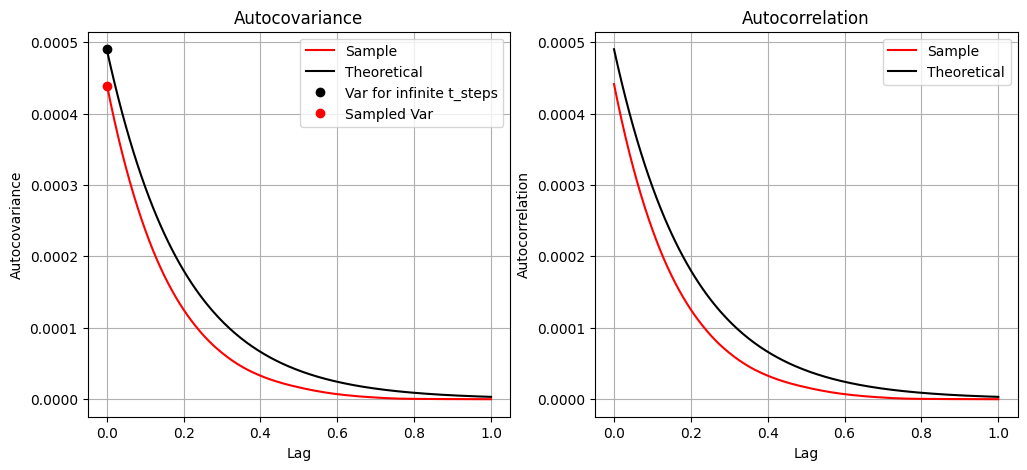

In [5]:
# Plotting Auto-covariance and Auto-correlation
# Compute autocovariance
t_lags = t_steps

sample_acov = np.zeros((N_STEPS * 2 + 1, N_SIMS))
for i in range(N_SIMS):
    sample_acov[:, i] = np.correlate(X[:, i] - exact_mean, X[:, i] - exact_mean, mode = "full") / N_STEPS
sample_acov = sample_acov[N_STEPS:].mean(axis = 1)
exact_acov = SIGMA**2 / (2*ALPHA) * np.exp(-ALPHA * t_lags)

# Compute autocorrelation
sample_acor = sample_acov / sample_acov[0]
exact_acor = np.exp(-ALPHA * t_lags)

# Plotting ============================================================================
fig, ax = plt.subplots(1, 2, figsize = (12, 5), clear = True)

# Auto-covariance ---------------------------------------------------------------------
ax[0].set_title("Autocovariance")
ax[0].plot(t_lags, sample_acov, color = "red", label = "Sample")
ax[0].plot(t_lags, exact_acov, color = "black", label = "Theoretical")

# Plotting sample and theoretical variance
ax[0].plot(0, SIGMA**2 / (2 * ALPHA), 'o', color = "black", label = 'Var for infinite t_steps')
ax[0].plot(0, np.mean(np.var(X, axis=1)), 'o', color = "red", label = 'Sampled Var')

ax[0].legend()
ax[0].grid()
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Autocovariance")

# Auto-correlation --------------------------------------------------------------------
ax[1].set_title("Autocorrelation")

ax[1].plot(t_steps, sample_acov, color = "red", label = "Sample")
ax[1].plot(t_steps, exact_acov, color = "black", label = "Theoretical")

ax[1].grid()
ax[1].legend()
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Autocorrelation")

plt.show()

$ C(\tau) = \frac{\sigma^2}{2\alpha} \exp(-\alpha |\tau|) $